In [1]:
import numpy as np
import pandas as pd
import pickle
import project_tools as tools
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [32]:
original_stats, original_games, original_records, original_teams, original_spread, original_rankings = tools.load_data_pkl()

In [33]:
original_spread

,season,seasonType,week,gameId,homeTeam,awayTeam,spread,homeWinProb
0,2013,regular,1,332432005,Air Force,Colgate,-31.5,0.968
1,2013,regular,1,332420012,Arizona,Northern Arizona,-35.0,0.980
2,2013,regular,1,332430008,Arkansas,Louisiana,-14.0,0.795
3,2013,regular,1,332432032,Arkansas State,Arkansas-Pine Bluff,-17.5,0.848
4,2013,regular,1,332420349,Army,Morgan State,-31.0,0.966
...,...,...,...,...,...,...,...,...
6111,2020,regular,16,401260158,Tennessee,Texas A&M,13.5,0.214
6112,2020,regular,16,401269376,UCLA,Stanford,-6.5,0.649
6113,2020,regular,16,401249434,USC,Oregon,-3.0,0.570
6114,2020,regular,16,401269375,Utah,Washington State,-11.5,0.751


In [61]:
games = tools.get_games_df('train')

In [62]:
games

,id,season,week,home_team,away_team,excitement_index,result,spread,homeWinProb,home_games,away_games,thirdDowns_spread,fumblesRecovered_spread,penaltyYards_spread,kickReturnTDs_spread,netPassingYards_spread,rushingAttempts_spread,rushingTDs_spread,passAttempts_spread,puntReturns_spread,rushingYards_spread,fourthDowns_spread,kickReturnYards_spread,interceptionYards_spread,firstDowns_spread,fourthDownConversions_spread,passesIntercepted_spread,totalYards_spread,passingTDs_spread,passCompletions_spread,puntReturnTDs_spread,possessionTime_spread,thirdDownConversions_spread,interceptions_spread,puntReturnYards_spread,penalties_spread,turnovers_spread,fumblesLost_spread,kickReturns_spread,interceptionTDs_spread,tacklesForLoss_spread,sacks_spread,home_for,home_against,away_for,away_against,away_wins,home_wins
0,332412579,2013,1,South Carolina,North Carolina,4.258906,17.0,11.5,0.751,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,332410135,2013,1,Minnesota,UNLV,5.598996,28.0,17.0,0.841,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,332412116,2013,1,UCF,Akron,4.055377,31.0,28.0,0.950,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,332410189,2013,1,Bowling Green,Tulsa,5.352316,27.0,-3.0,0.430,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,332410254,2013,1,Utah,Utah State,7.013360,4.0,4.5,0.604,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,401056705,2018,14,Georgia,Alabama,7.803290,-7.0,-12.0,0.240,12.0,12.0,0.750000,0.250000,1.083333,-0.083333,-62.833333,4.250000,0.083333,-1.916667,0.333333,65.500000,-0.083333,-13.500000,-8.250000,0.750000,0.166667,-0.583333,2.666667,-0.583333,-1.166667,0.083333,193.916667,0.166667,0.083333,6.000000,0.416667,0.083333,0.000000,-0.500000,-0.250000,-3.083333,-1.583333,40.083333,17.166667,49.000000,13.750000,11.0,10.0
4151,401056700,2018,14,Boise State,Fresno State,8.524009,-3.0,1.5,0.535,12.0,12.0,1.166667,0.666667,5.500000,0.000000,-3.750000,-0.583333,-0.500000,1.916667,0.666667,1.666667,0.916667,-2.166667,-20.750000,1.333333,0.500000,-1.000000,-2.083333,0.083333,0.500000,0.000000,-53.083333,1.416667,0.333333,4.583333,0.083333,0.250000,-0.083333,0.250000,-0.166667,1.000000,1.166667,37.000000,22.333333,36.250000,13.500000,8.0,11.0
4152,401056697,2018,14,Pittsburgh,Clemson,0.534431,-32.0,-28.0,0.050,12.0,12.0,1.500000,0.083333,33.833333,0.166667,-105.833333,4.166667,-1.000000,-8.750000,-1.416667,-1.416667,0.333

## Single Variable Linear Regression

In [5]:
pd.options.display.max_columns = None
train = games[games['season'] < 2018]
valid = games[games['season'] == 2018]

X_train = train['home_wins'].to_numpy() - train['away_wins'].to_numpy()
y_train = train['result'].to_numpy()

X_valid = valid['home_wins'].to_numpy() - valid['away_wins'].to_numpy()
y_valid = valid['result'].to_numpy()

In [113]:
pd.options.display.max_columns = None
train = games[games['season'] < 2018]
valid = games[games['season'] == 2018]

X_train = train['totalYards_spread'].to_numpy()
y_train = train['result'].to_numpy()

X_valid = valid['totalYards_spread'].to_numpy()
y_valid = valid['result'].to_numpy()

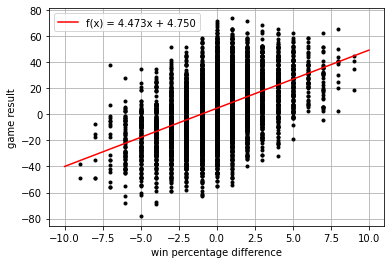

In [7]:
baseline_model = LinearRegression().fit(X_train.reshape(-1, 1), y_train)

x = np.linspace(-10, 10, 500)
y = baseline_model.coef_[0] * x + baseline_model.intercept_

plt.xlabel('win percentage difference')
plt.ylabel('game result')
plt.plot(X_train, y_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_[0], baseline_model.intercept_))
plt.legend()
plt.grid()

In [8]:
prediction_train = baseline_model.predict(X_train.reshape(-1, 1))
prediction_valid = baseline_model.predict(X_valid.reshape(-1, 1))
print('RMSE on train = %.2f points' % mean_squared_error(y_train, prediction_train, squared=False))
print('RMSE on valid = %.2f points' % mean_squared_error(y_valid, prediction_valid, squared=False))

RMSE on train = 18.97 points
RMSE on valid = 19.74 points


## Ridge Regression Baseline

In [63]:
X= games.drop(['home_team','away_team','result'], axis=1).to_numpy()
y = games['result']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [64]:
LinRegMod = LinearRegression()
LinRegMod.fit(X_train, y_train)

LinearRegression()

In [65]:
pred_train = LinRegMod.predict(X_train)
print('RMSE on train = %.2f points' % mean_squared_error(y_train, pred_train, squared=False))
print(f'Percent Correct (W/L) = {np.sum(np.sign(pred_train)==np.sign(y_train))/len(y_train)*100:.4}%\n')

pred_valid = LinRegMod.predict(X_valid)
print('RMSE on valid = %.2f points' % mean_squared_error(y_valid, pred_valid, squared=False))
print(f'Percent Correct (W/L) = {np.sum(np.sign(pred_valid)==np.sign(y_valid))/len(y_valid)*100:.4}%')

RMSE on train = 15.79 points
Percent Correct (W/L) = 75.85%

RMSE on valid = 15.94 points
Percent Correct (W/L) = 75.0%


## Playing around with a Neural Net

In [175]:
torch.manual_seed(0)
device = torch.device("cpu")
print('Using device', device)

Using device cpu


In [176]:
train_in = games.drop(columns=['home_team','away_team','result'])
train_out = games.result

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out.to_numpy(), dtype=torch.float, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

In [177]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(45, 15)
        self.h2 = nn.Linear(15, 5)
        self.output = nn.Linear(5,1)
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.h1(x)
        x = self.h2(x)
        x = self.output(x)
        return x
    
def train(model, device, train_loader, optimizer, epochs, criterion, verbose=False, log_freq = 10):
    loss_log  = []
    for epoch in range(epochs):
        model.train()
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        if verbose & (epoch%log_freq==0):
            print('Train Epoch: %d  \tLoss: %.6f' % (epoch, loss.item()/len(data)))
        loss_log.append(loss.item()/len(data))
    return loss_log
            
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += criterion(output, label).item()
    print('Test set: Average loss: %.4f' % np.sqrt(test_loss/len(test_loader)))

    return test_loss

model = Network()

In [178]:
# model = nn.Sequential(nn.Linear(45,1))

In [184]:
BATCH_SIZE = 200
EPOCHS = 1000
LEARNING_RATE = 0.00001
MOMENTUM = 0.5

In [185]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [186]:
loss_log = train(model, device, train_loader, optimizer, EPOCHS, criterion, verbose=True, log_freq=75)

Train Epoch: 0  	Loss: 41551.219355
Train Epoch: 75  	Loss: 5.216009
Train Epoch: 150  	Loss: 1360.730948
Train Epoch: 225  	Loss: 87.961240
Train Epoch: 300  	Loss: 111.040058
Train Epoch: 375  	Loss: 42.713596
Train Epoch: 450  	Loss: 12.136426
Train Epoch: 525  	Loss: 1018.695766
Train Epoch: 600  	Loss: 58.348374
Train Epoch: 675  	Loss: 124.834047
Train Epoch: 750  	Loss: 49.692550
Train Epoch: 825  	Loss: 63.889201
Train Epoch: 900  	Loss: 160.405759
Train Epoch: 975  	Loss: 3.646547


Text(0.5, 1.0, 'Training Linear NN')

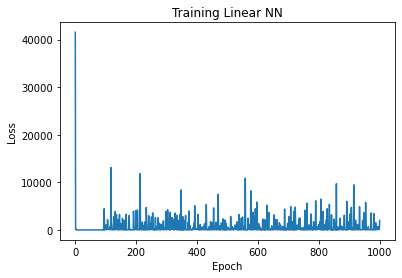

In [187]:
plt.plot(loss_log)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training Linear NN')

In [188]:
l = test(model, device, train_loader, criterion)

Test set: Average loss: 641.7328
